На второй неделе мы продолжим подготавливать данные для дальнейшего анализа и построения прогнозных моделей. Конкретно, раньше мы определили что сессия – это последовательность из 10 посещенных пользователем сайтов, теперь сделаем длину сессии параметром, и потом при обучении прогнозных моделей выберем лучшую длину сессии. Также мы познакомимся с предобработанными данными и статистически проверим первые гипотезы, связанные с нашими наблюдениями.

План 2 недели:

Часть 1. Подготовка нескольких обучающих выборок для сравнения
Часть 2. Первичный анализ данных, проверка гипотез
В этой части проекта Вам могут быть полезны следующие видеозаписи лекций курса "Построение выводов по данным":

Доверительные интервалы для доли
Биномиальный критерий для доли
Доверительные интервалы на основе бутстрепа
Кроме того, в задании будут использоваться библиотеки Python glob, pickle, itertools и класс csr_matrix из scipy.sparse.

# Часть 1. Подготовка нескольких обучающих выборок для сравнения

Пока мы брали последовательности из 10 сайтов, и это было наобум. Давайте сделаем число сайтов в сессии параметром, чтоб в дальнейшем сравнить модели классификации, обученные на разных выборках – с 5, 7, 10 и 15 сайтами в сессии. Более того, пока мы брали по 10 сайтов подряд, без пересечения. Теперь давайте применим идею скользящего окна – сессии будут перекрываться.

Пример: для длины сессии 10 и ширины окна 7 файл из 30 записей породит не 3 сессии, как раньше (1-10, 11-20, 21-30), а 5 (1-10, 8-17, 15-24, 22-30, 29-30). При этом в предпоследней сессии будет один ноль, а в последней – 8 нолей.

Создадим несколько выборок для разных сочетаний параметров длины сессии и ширины окна. Все они представлены в табличке ниже:

Итого должно получиться 18 разреженных матриц – указанные в таблице 9 сочетаний параметров формирования сессий для выборок из 10 и 150 пользователей. При этом 2 выборки мы уже сделали в прошлой части, они соответствуют сочетанию параметров: session_length=10, window_size=10, которые помечены в таблице выше галочкой зеленого цвета (done).

Реализуйте функцию prepare_sparse_train_set_window.

Аргументы:

path_to_csv_files – путь к каталогу с csv-файлами;

site_freq_path – путь к pickle-файлу с частотным словарем, полученным в 1 части проекта

session_length – длина сессии (параметр)

window_size – ширина окна (параметр)

Функция должна возвращать 2 объекта:

- разреженную матрицу X_sparse (двухмерная Scipy.sparse.csr_matrix), в которой строки соответствуют сессиям из session_length сайтов, а max(site_id) столбцов – количеству посещений site_id в сессии.
- вектор y (Numpy array) "ответов" в виде ID пользователей, которым принадлежат сессии из X_sparse

Детали:

- Модифицируйте созданную в 1 части функцию prepare_train_set
- Некоторые сессии могут повторяться – оставьте как есть, не удаляйте дубликаты
- Замеряйте время выполнения итераций цикла с помощью time из time, tqdm из tqdm или с помощью виджета log_progress (статья о нем на Хабрахабре)
- 150 файлов из capstone_websites_data/150users/ должны обрабатываться за несколько секунд (в зависимости от входных параметров). Если дольше – не страшно, но знайте, что функцию можно ускорить.

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

In [3]:
def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, 
                                    session_length=10, window_size=10):
    sessions_list = []
    with open(site_freq_path, 'rb') as f:
        freq_dict = pickle.load(f)
    users_files = sorted(glob(os.path.join(path_to_csv_files, 'user[0-9][0-9][0-9][0-9].csv')))
    for user in tqdm(users_files):
        site_list = pd.read_csv(user).site.values
        session = {}  # Current session
        for i in range(0, len(site_list), window_size):
            window = site_list[i: i + session_length]
            for j, site in enumerate(window):
                session['site{}'.format(j + 1)] = freq_dict[site][0]
            session['user_id'] = int(user.strip('.csv')[-4:])
            sessions_list.append(session)
            session = {}
    # Creating a DataFrame from the sessions_list
    columns = ['site{}'.format(i + 1) for i in range(session_length)] + ['user_id']
    dframe = pd.DataFrame(sessions_list, columns = columns).fillna(0).astype(int)
    X, y = dframe.iloc[:, :-1].values, dframe.iloc[:, -1].values
    # Creating a sparse matrix
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for session in X:
        for site in session:
            index = vocabulary.setdefault(site, site)
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    X_sparse = csr_matrix((data, indices, indptr))[:,1:]
    return X_sparse, y

Примените полученную функцию с параметрами session_length=5 и window_size=3 к игрушечному примеру. Убедитесь, что все работает как надо.

In [4]:
X_toy_s5_w3, y_s5_w3 = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA,'3users'), 
                                                       os.path.join(PATH_TO_DATA,'site_freq_3users.pkl'),
                                       session_length=5, window_size=3)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 214.82it/s]


In [5]:
# Sparse matrix.
X_toy_s5_w3.todense()

matrix([[0, 3, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
        [3, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [6]:
# Answers vector.
y_s5_w3

array([1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3])

Запустите созданную функцию 16 раз с помощью циклов по числу пользователей num_users (10 или 150), значениям параметра session_length (15, 10, 7 или 5) и значениям параметра window_size (10, 7 или 5). Сериализуйте все 16 разреженных матриц (обучающие выборки) и векторов (метки целевого класса – ID пользователя) в файлы X_sparse_{num_users}users_s{session_length}_w{window_size}.pkl и y_{num_users}users_s{session_length}_w{window_size}.pkl.

Чтоб убедиться, что мы все далее будем работать с идентичными объектами, запишите в список data_lengths число строк во всех полученных рареженных матрицах (16 значений). Если какие-то будут совпадать, это нормально (можно сообразить, почему).

На моем ноутбуке этот участок кода отработал за 26 секунд, хотя понятно, что все зависит от эффективности реализации функции prepare_sparse_train_set_window и мощности используемого железа. И честно говоря, моя первая реализация была намного менее эффективной (34 минуты), так что тут у Вас есть возможность оптимизировать свой код.

In [7]:
%%time
import itertools

data_lengths = []

for num_users in [10, 150]:
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if window_size <= session_length and (window_size, session_length) != (10, 10):
            X_sparse, y = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA,'{}users'.format(num_users)), 
                                                       os.path.join(PATH_TO_DATA,'site_freq_150users.pkl'),
                                       session_length, window_size)
            with open(os.path.join(PATH_TO_DATA, 
                                   'X_sparse_{}users_s{}_w{}.pkl'.format(num_users, 
                                                                         session_length, 
                                                                         window_size)), 'wb') as f1:
                pickle.dump(X_sparse, f1, protocol=2)
            with open(os.path.join(PATH_TO_DATA, 
                                   'y_{}users_s{}_w{}.pkl'.format(num_users, 
                                                                  session_length, 
                                                                  window_size)), 'wb') as f2:
                pickle.dump(y, f2, protocol=2)
            data_lengths.append(X_sparse.shape[0])

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 59.17it/s]


Wall time: 51.2 s


Запишите в файл answer2_1.txt все числа из списка data_lengths через пробел. Полученный файл будет ответом на 1 вопрос теста.

In [8]:
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

In [9]:
write_answer_to_file(' '.join(map(str, data_lengths)), 
                     'answers/answer2_1.txt')

# Часть 2. Первичный анализ данных, проверка гипотез

Считаем в DataFrame подготовленный на 1 неделе файл train_data_10users.csv. Далее будем работать с ним.

In [10]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), 
                       index_col='session_id')

In [11]:
train_df.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
session_id,,,,,,,,,,,
0,192,574,133,3,133,133,3,133,203,133,31
1,415,193,674,254,133,31,393,3305,217,55,31
2,55,3,55,55,5,293,415,333,897,55,31
3,473,3306,473,55,55,55,55,937,199,123,31
4,342,55,5,3307,258,211,3308,2086,675,2086,31


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14061 entries, 0 to 14060
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   site1    14061 non-null  int64
 1   site2    14061 non-null  int64
 2   site3    14061 non-null  int64
 3   site4    14061 non-null  int64
 4   site5    14061 non-null  int64
 5   site6    14061 non-null  int64
 6   site7    14061 non-null  int64
 7   site8    14061 non-null  int64
 8   site9    14061 non-null  int64
 9   site10   14061 non-null  int64
 10  user_id  14061 non-null  int64
dtypes: int64(11)
memory usage: 1.3 MB


Распределение целевого класса:

In [13]:
train_df['user_id'].value_counts()

128    2796
39     2204
207    1868
127    1712
237    1643
33     1022
50      802
31      760
100     720
241     534
Name: user_id, dtype: int64

Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов

In [14]:
num_unique_sites = [np.unique(train_df.values[i, :-1]).shape[0] 
                    for i in range(train_df.shape[0])]

In [15]:
pd.Series(num_unique_sites).value_counts()

7     2308
6     2197
8     2046
5     1735
9     1394
2     1246
4     1163
3      894
10     651
1      427
dtype: int64

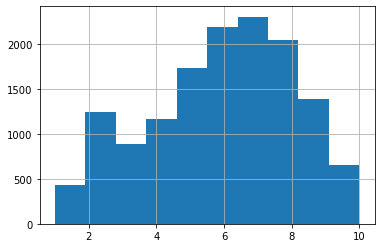

In [16]:
pd.Series(num_unique_sites).hist();

Проверьте с помощью QQ-плота и критерия Шапиро-Уилка, что эта величина распределена нормально. Сделайте вывод. Ответом на второй вопрос в тесте будет файл со словом "YES" или "NO" в зависимости от того, распределено ли нормально число уникальных сайтов в сессии

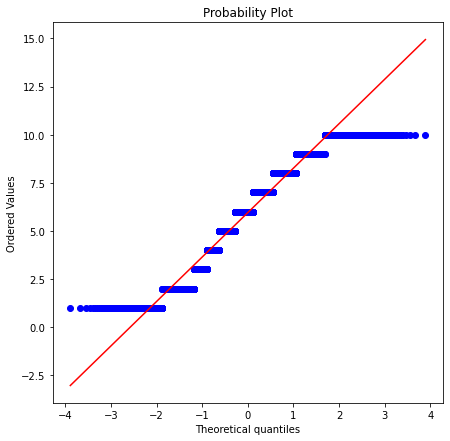

In [17]:
plt.figure(figsize=(7, 7))
stats.probplot(num_unique_sites, dist='norm', plot = plt)
plt.show()

In [18]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(num_unique_sites))

Shapiro-Wilk normality test, W-statistic: 0.954693, p-value: 0.000000


In [19]:
write_answer_to_file('NO', 
                     'answers/answer2_2.txt')

Проверьте гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов. Давайте проверим с помощью биномиального критерия для доли, что доля случаев, когда пользователь повторно посетил какой-то сайт (то есть число уникальных сайтов в сессии < 10) велика: больше 95% (обратите внимание, что альтернатива тому, что доля равна 95% – одностороняя). Ответом на 3 вопрос в тесте будет полученное p-value.

In [20]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')

In [21]:
pi_val = stats.binom_test(has_two_similar.sum(), len(has_two_similar), p=0.95, alternative='greater')
print('Binomial test p-value: {}'.format(pi_val))

Binomial test p-value: 0.02207653769072678


In [22]:
write_answer_to_file(str(pi_val), 
                     'answers/answer2_3.txt')

Постройте для этой доли 95% доверительный интервал Уилсона. Округлите границы интервала до 3 знаков после запятой и запишите через пробел в файл answer2_4.txt. Это будет ответом на 4 вопрос теста.

In [23]:
wilson_interval = proportion_confint(has_two_similar.sum(), len(has_two_similar))
print('wilson_interval [%f, %f] with width %f' % (wilson_interval[0],
                                                  wilson_interval[1],
                                                  wilson_interval[1] - wilson_interval[0]))

wilson_interval [0.950229, 0.957175] with width 0.006946


In [24]:
write_answer_to_file('{} {}'.format(round(wilson_interval[0], 3),
                                   round(wilson_interval[1], 3)), 
                     'answers/answer2_4.txt')

Постройте распределение частоты посещения сайтов (сколько раз тот или иной сайт попадается в выборке) для сайтов, которые были посещены как минимум 1000 раз.

In [25]:
site_freqs = pd.Series(train_df.values[:, :-1].reshape(-1)).value_counts()

<AxesSubplot:>

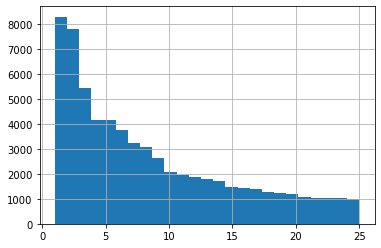

In [26]:
more_1k_freq = [site for site in train_df.values[:, :-1].reshape(-1) if site_freqs[site] >= 1000]
pd.Series(more_1k_freq).hist(bins=25)

Постройте 95% доверительный интервал для средней частоты появления сайта в выборке (во всей, уже не только для тех сайтов, что были посещены как минимум 1000 раз) на основе bootstrap. Используйте столько же bootstrap-подвыборок, сколько сайтов оказалось в исходной выборке по 10 пользователям. Берите подвыборки из посчитанного списка частот посещений сайтов – не надо заново считать эти частоты. Учтите, что частоту появления нуля (сайт с индексом 0 появлялся там, где сессии были короче 10 сайтов) включать не надо. Округлите границы интервала до 3 знаков после запятой и запишите через пробел в файл answer2_5.txt. Это будет ответом на 5 вопрос теста.

In [27]:
def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [28]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, 
                 [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [29]:
mean_freq_list = list(map(np.mean, get_bootstrap_samples(site_freqs.values, len(site_freqs))))
mean_freq_int = stat_intervals(mean_freq_list, 0.05)
print('95% confidence interval for mean frequency: ' + str(mean_freq_int))

95% confidence interval for mean frequency: [22.51415344 35.75545381]


In [30]:
write_answer_to_file('{} {}'.format(round(mean_freq_int[0], 3), round(mean_freq_int[1], 3)), 
                                    'answers/answer2_5.txt')

# Пути улучшения

В этом проекте свобода творчества на каждом шаге, а 7 неделя проекта посвящена общему описанию (html, ipynb или pdf) и взаимному оцениванию проектов. Что еще можно добавить по второй части проекта:

можно дополнительно рассматривать сессии с параметром – длиной сессии по времени. И составить выборки, скажем, для 5-, 10-, 15- и 20-минутных сессий (это как раз пригодится в соревновании Kaggle Inclass)
можно провести больше первичного анализа и проверять прочие интересные гипотезы (а больше их появится после создания признаков на следующей неделе)
На 3 неделе мы займемся визуальным анализом данных и построением признаков.